In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Problem 1
model as 1D problem, with equation:
$$\frac{\partial C}{\partial t} = D\frac{\partial^2 C}{\partial x^2}$$

Where $C$ is the diffusion ccoefficient. We assume that at t0, the dye injeted at x0 is a delta function in concentration.

The section we are looking at is 10 units long ($0\leq x \leq 10$) and $x0=5$ and $D=0.1$. Boundary conditions are $C(0,t)=C(10,t)=0$.

Number of cells is $N$ so number of points is $N+1$. Our initial condition is $t=2$ from the exact solution. We time step from $t=2$ to $t=4$ on a grid with $N=100$ points with RK4 time stepping, crank nicolson. For RK4 we report the stable time step, and for crank-nicolson, we show the scheme is stable for large CFL. Note that we will need to use a tridiagonal solver to solve the system of equations. The Thomas Algorithm (a tridiagonal solver) is available online, and copy pasted below.

In [269]:
try:
   import numpypy as np    # for compatibility with numpy in pypy
except:
   import numpy as np      # if using numpy in cpython

def TDMASolve(a, b, c, d):
    n = len(a)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    xc = []
    for j in range(1, n):
        if(bc[j - 1] == 0):
            ier = 1
            return
        ac[j] = ac[j]/bc[j-1]
        bc[j] = bc[j] - ac[j]*cc[j-1]
    if(b[n-1] == 0):
        ier = 1
        return
    for j in range(1, n):
        dc[j] = dc[j] - ac[j]*dc[j-1]
    dc[n-1] = dc[n-1]/bc[n-1]
    for j in range(n-2, -1, -1):
        dc[j] = (dc[j] - cc[j]*dc[j+1])/bc[j]
    return dc

In [911]:
L = 10
D = 0.1
x0 = 5

N = 200
numpts = N+1
dx = L/N
print(dx)



def initial(x,t):
    C = 1/math.sqrt(4*math.pi*D*t)*np.exp(-(x-x0)**2/(4*D*t))
    return C



0.05


In [5]:
# test = np.arange(1,N-1)
# print(test)
# print(2*test)
empty = np.zeros((3,3))
vec = np.array([1,2,3])
# vec = np.reshape(vec,(-1,1))
vec = np.reshape(vec,(-1))
empty[:,2] = vec
print(empty)

[[0. 0. 1.]
 [0. 0. 2.]
 [0. 0. 3.]]


In [492]:


# This gives the slope dC/dt=D*d^2C/dx^2 at each point in x for the solution vector C(x)
def Cent2(fold):
    # print(fold.shape)
    RHSvec = np.zeros(N-1)
    for xindex in np.arange(1,N-1):
        xindex = int(xindex)
        RHSvec[xindex] = D*(fold[xindex+1]-2*fold[xindex]+fold[xindex-1])/dx**2
    RHSvec = np.insert(RHSvec, 0, 0)
    RHSvec = np.insert(RHSvec, N-1, 0)
    # print(RHSvec.shape)
    print('RHSvec')
    print(RHSvec)
    return RHSvec

#Next, we want to use the slope evaluations to compute the values at the next time step
def RK4(fold,Spatial=Cent2):
    K0 = Spatial(fold) #Each K variable is a vector of K values
    K1 = Spatial(fold+dt/2*K0)
    K2 = Spatial(fold+dt*K1/2)
    K3 = Spatial(fold+dt*K2)
    fn = fold + (K0+2*K1+2*K2+K3)*dt/6
    return fn

    
#Creates the matrix A that multiplies the vector C^(k+1)
def getA(CFL,N):
    A = np.empty((N-1,N-1))
    for i in range(N-1):
        for j in range(N-1):
            if i == j:
                A[i,j] = 1 + CFL
            elif i == j + 1  or i == j - 1:
                A[i,j] = -CFL/2
    return A

#Creates the matrix B that multiplies the vector C^k
def getB(CFL,N):
    B = np.empty((N-1,N-1))
    for i in range(N-1):
        for j in range(N-1):
            if i == j:
                B[i,j] = 1 - CFL
            elif i == j + 1  or i == j - 1:
                B[i,j] = CFL/2
    return B

def crkncl(Cvec,CFL):
    A = getA(CFL,N)
    Ainv = np.linalg.inv(A)
    Cveck1 = Ainv*B*Cvec
    return Cveck1

In [936]:
# A = getA(CFL,N)
# print(A)
# B = getB(CFL,N)
# print(B)

In [943]:
def solve(dt=0.1,method=RK4,printvals=False):
    tfinal = 4
    simlength = tfinal-2
    numtsteps = int(simlength/dt)
    x = np.linspace(dx,L-dx,N-1)
    # print(x)
    Cvec0 = initial(x,2)
    Cvec0 = np.insert(Cvec0, 0, 0)
    Cvec0 = np.insert(Cvec0, N, 0)
    # print(Cvec0)
    soln = np.zeros((N+1,numtsteps+1))
    # print(soln.shape)
    soln[:,0] = Cvec0
    
    CFL = D*dt/dx**2
    print('CFL = ' + str(CFL))
    
    # diagnostics for initial condition, simulation inputs
    if printvals:
        print('dt = '+str(dt))
        print('t = 2')
        print('tstep = 0')
        # print(Cvec0)
    
    # perform the calcualation
    for tstep in range(1,numtsteps+1):
        t = tstep*dt + 2
        Cvec = soln[:,tstep-1]
        if method == RK4:
            Cveck1 = method(Cvec,dt)
        elif method == crkncl:
            Cveck1 = method(Cvec,CFL)
        # Need to make it so that the method only evaluates fnew for elements 1 thru N-1, instead of 0 thru N
        # because at 0 and N, we require C=0
        soln[:,tstep] = Cveck1
        # diagnostics for each time step
        if printvals:
            print('t = ' + str(t))
            print('tstep = ' + str(tstep))
            # print(Cveck1)
            print('row 0: x=0')
            print(soln[0,:])
            print('row 1: x=dx')
            print(soln[1,:])
    # prepare x vector for packaging
    x = np.insert(x,0,0)
    x = np.insert(x,N,10)
    x = np.reshape(x,(-1,1))
    # print(x.shape)
    # print(soln.shape)
    
    # package the result
    packagedsoln = np.append(soln,x,1)
    # print(packagedsoln[:,-1])
    return packagedsoln

In [944]:
# soln = solve(dt=0.1,method=RK4,printvals=False)
# soln = solve(dt=0.01,method=crkncl,printvals=False)

In [1056]:
# Want to define a plotting function that will plot:
# the initial condition at t=2
# the true solution at t=4
# the numerical solution at t=4 for 3-4 dt values

def plotpr1(method,dtvals,filename=[]):
    
    #initialize figure
    plt.figure(figsize=(10,5))
    axes_internal = plt.gca()
    axes_internal.set_xlabel('$x$')
    axes_internal.set_ylabel('$C$')
    
    #initialize storage and index
    # solns = np.empty((N+1,dtvals.size+1))
    # i = 0
    for dt in dtvals:
        # which dtval/iteration of the loop we are looking at. 1st is 1, nth loop is n
        # i += 1
        
        #solve the problem
        soln = solve(dt,method,printvals=False)
        
        # unpack the solution matrix
        x = soln[:,-1]
        Cvecfinal = soln[:,-2]
        
        # # save relevant values to solution matrix
        # solns[:,0] = x #this will overwrite for every dtval, could be written outside of loop instead...
        # solns[:,i] = Cvecfinal
        plt.plot(x,Cvecfinal, label='$\Delta t=$'+str(dt))
        # timesteps = [int(0.5/dt), int(1/dt), int(1.5/dt), int(2/dt)]
        # for timestep in timesteps:
        #     plt.plot(x,soln[:,timestep], label='t =' + str(timestep*dt) + ', dt = ' + str(dt))
        
        
    # get initial condition, this is computed both every time we solve, as well as here.. could be improved
    Cvec2 = initial(x,2) #was called Cvec0 inside the solution function
    Cvec4 = initial(x,4)
    
    plt.plot(x,Cvec2, label='Exact solution, t=2')
    plt.plot(x,Cvec4, label='Exact solution, t=4')
    
    plt.legend(loc = 'upper right')
    if len(filename) != 0:
        print(filename+'.png')
        plt.savefig(filename+'.png')
    plt.show()
    return None
    

CFL = 0.7479999999999999
RK4Pr1.png


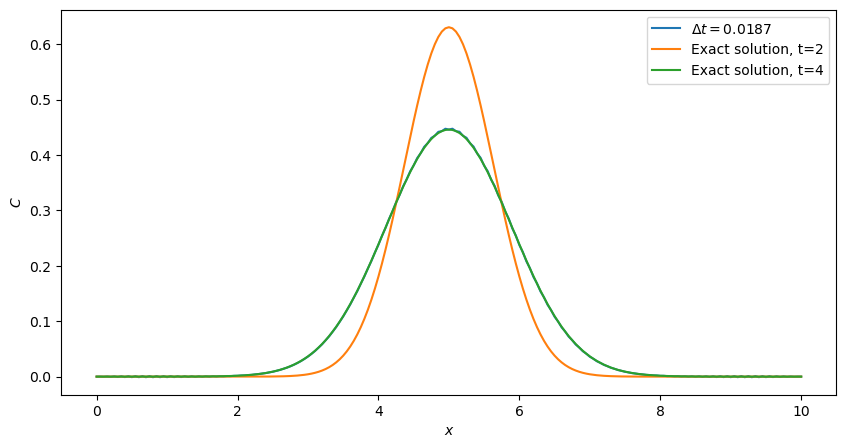

CFL = 79.99999999999999
CFL = 19.999999999999996
CFL = 4.0
crknclPr1_.png


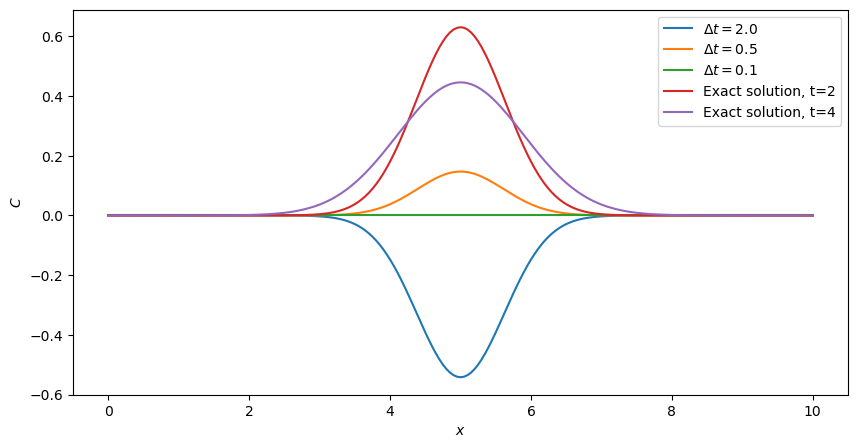

In [1055]:
dtvals = np.array([0.0187]) #
#0.0186 appears to be the limit before we start seeing visible oscillations

plotpr1(RK4,dtvals,filename="RK4Pr1")
dtvals = np.array([2,0.5,0.1])
plotpr1(crkncl,dtvals,filename="crknclPr1_")

In [1017]:
for tstepm1 in range(0,numtsteps):
    print(tstepm1)

0
1
2
3
4
5
6
7
8
9
